image.shape = (295, 300)


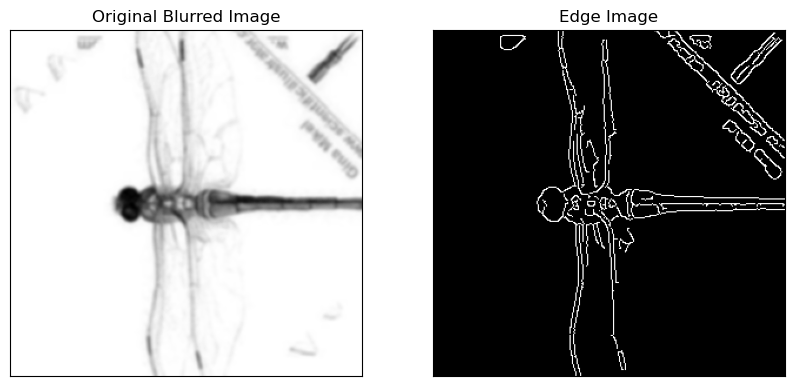

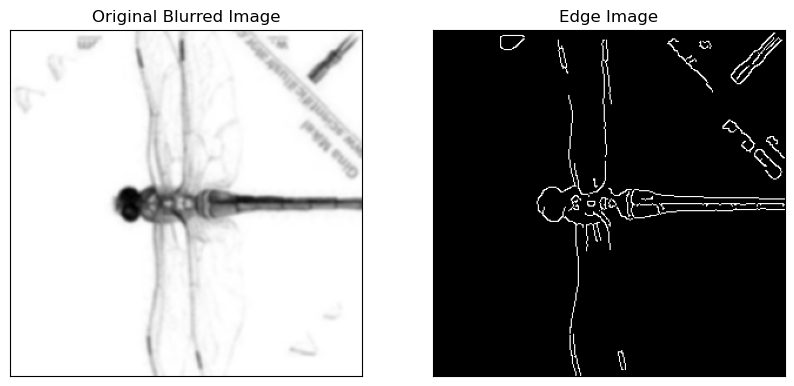

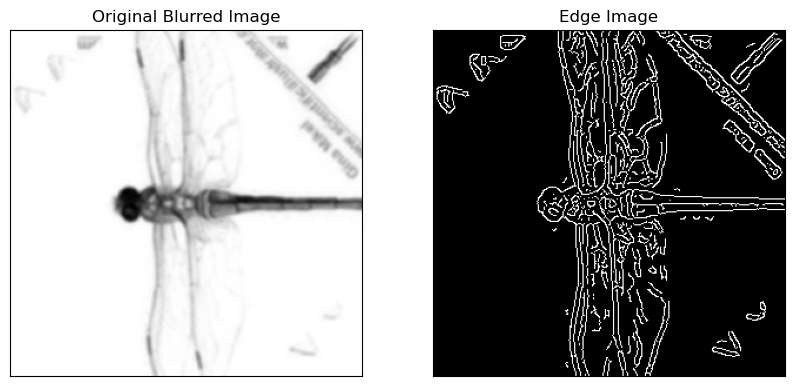

Feature Set 1:
Canny Parameters: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
SIFT Parameters: {'nfeatures': 500, 'contrastThreshold': 0.04}
Descriptors Shape: (186, 128)

Feature Set 2:
Canny Parameters: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
SIFT Parameters: {'nfeatures': 800, 'contrastThreshold': 0.03}
Descriptors Shape: (186, 128)

Feature Set 3:
Canny Parameters: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
SIFT Parameters: {'nfeatures': 1000, 'contrastThreshold': 0.02}
Descriptors Shape: (186, 128)

Feature Set 4:
Canny Parameters: {'threshold1': 100, 'threshold2': 200, 'apertureSize': 3}
SIFT Parameters: {'nfeatures': 500, 'contrastThreshold': 0.04}
Descriptors Shape: (89, 128)

Feature Set 5:
Canny Parameters: {'threshold1': 100, 'threshold2': 200, 'apertureSize': 3}
SIFT Parameters: {'nfeatures': 800, 'contrastThreshold': 0.03}
Descriptors Shape: (90, 128)

Feature Set 6:
Canny Parameters: {'threshold1': 100, 'threshold2': 200, 'apertu

array([[40.,  2.,  1., ...,  0.,  0.,  0.],
       [ 8., 51., 47., ..., 19.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [52.,  5.,  0., ...,  0.,  0.,  0.],
       [70.,  7.,  7., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  4.,  0.,  2.]], dtype=float32)

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('First50/dragonfly/image_0002.jpg', cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

canny_params = [
    {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3},
    {'threshold1': 100, 'threshold2': 200, 'apertureSize': 3},
    {'threshold1': 150, 'threshold2': 250, 'apertureSize': 5}
]

sift_params = [
    {'nfeatures': 500, 'contrastThreshold': 0.04},
    {'nfeatures': 800, 'contrastThreshold': 0.03},
    {'nfeatures': 1000, 'contrastThreshold': 0.02}
]
print(f"image.shape = {blurred_image.shape}")
feature_sets = []

for cp in canny_params:
    # Apply Canny edge detection with varying parameters
    edges = cv2.Canny(blurred_image, cp['threshold1'], cp['threshold2'], apertureSize=cp['apertureSize'])
    plt.figure(figsize=(10, 5))

    plt.subplot(121), plt.imshow(blurred_image, cmap='gray')
    plt.title('Original Blurred Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()
    
    for sp in sift_params:
        # Apply SIFT descriptor extraction with varying parameters
        sift = cv2.SIFT_create(nfeatures=sp['nfeatures'], contrastThreshold=sp['contrastThreshold'])
        keypoints, descriptors = sift.detectAndCompute(edges, None)
        
        # Append the descriptors to the feature sets
        feature_sets.append({
            'canny_params': cp,
            'sift_params': sp,
            'descriptors': descriptors
        })

# Print the feature sets
for i, feature_set in enumerate(feature_sets):
    print(f"Feature Set {i+1}:")
    print(f"Canny Parameters: {feature_set['canny_params']}")
    print(f"SIFT Parameters: {feature_set['sift_params']}")
    print(f"Descriptors Shape: {feature_set['descriptors'].shape if feature_set['descriptors'] is not None else 'None'}")
    print()
feature_sets[0]['descriptors']
# You can save the feature sets or process them further as needed


image.shape = (128, 128)
HOG Descriptors shape: (34020,)


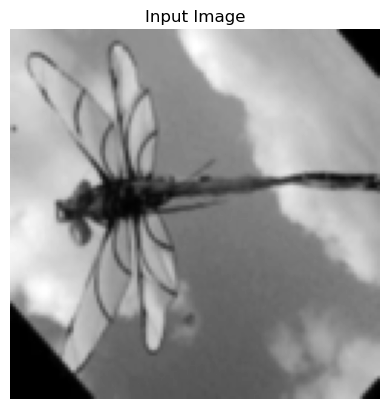

HOG Descriptors shape: (34020,)
4328.1655835176225


In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

orig_image = cv2.imread('First50/dragonfly/image_0003.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.GaussianBlur(orig_image, (5, 5), 1.4)
image = cv2.resize(image, (128,128))

print(f"image.shape = {image.shape}")

# hog = cv2.HOGDescriptor()
# Configure the HOG descriptor
hog_descriptor = cv2.HOGDescriptor(
    _winSize=(64, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)
# Compute the HOG descriptors
hog_descriptors = hog.compute(image)
print(f'HOG Descriptors shape: {hog_descriptors.shape}')

# Reshape the descriptors to a more manageable form (optional)
hog_descriptors = hog_descriptors.reshape(-1)

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

# Print the HOG descriptors
print(f'HOG Descriptors shape: {hog_descriptors.shape}')
print(sum(hog_descriptors))

In [43]:
import cv2
import numpy as np
import os
import glob

def preprocess_image(image_path, target_size=(128, 128)):
    orig_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.GaussianBlur(orig_image, (5, 5), 1.4)
    if image.shape[:2] != target_size:
        image = cv2.resize(image, target_size)
    return image

def extract_hog_features(image, hog_descriptor):
    return hog_descriptor.compute(image)

def load_data(image_paths, hog_descriptor):
    print("Started extracting descriptors...")
    hog_descriptors_list = []
    categories = []
    for image_path in image_paths:
        # print(f"Processing: {image_path}")
        category = os.path.basename(os.path.dirname(image_path))
        # print(f"category: {category}")
        if category not in categories:
            categories.append(category)
        image = preprocess_image(image_path, target_size=hog_descriptor.winSize)
        hog_descriptors = extract_hog_features(image, hog_descriptor)
        hog_descriptors_list.append(hog_descriptors)
    X = np.array(hog_descriptors_list, dtype=np.float32)
    X = X.reshape(X.shape[0], -1) # Reshape the feature array to (num_samples, num_features)
    print("Completed extracting descriptors.")
    print(f'categories: {categories}')
    print(f"X.shape = {X.shape}")
    return X

hog_descriptor = cv2.HOGDescriptor(
    _winSize=(128, 128),
    _blockSize=(16, 16),
    _blockStride=(8, 8),
    _cellSize=(8, 8),
    _nbins=9
)

image_files = glob.glob(f"First50/*/*.jpg")
print(f"image files: {len(image_files)}")
X = load_data(image_files, hog_descriptor)


image files: 5083
Started extracting descriptors...
Completed extracting descriptors.
categories: ['accordion', 'airplanes', 'anchor', 'ant', 'BACKGROUND_Google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter']
X.shape = (5083, 8100)


(5083, 3780)
